# FMCA Gaussian process learning

### first import modules

In [1]:
# import seems necessary to not crash matplotlib
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt
from pylab import figure, cm
import numpy as np
from numpy import linalg as la
import time
import scipy
from scipy.optimize import minimize
import FMCA

### generate data points and visualize them
(We force NumPy to use column major arrays for performance reasons)

(100, 2)


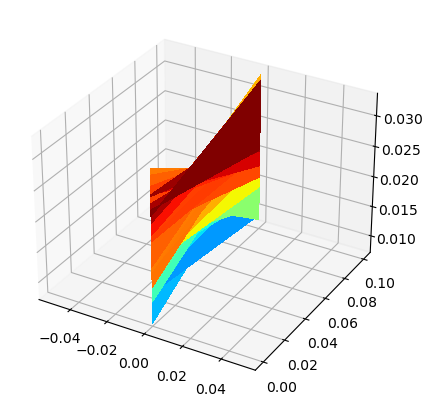

<Figure size 500x500 with 0 Axes>

In [2]:
dim = 2
N = 100

# add scaling isotropic
#hyperParameter = np.sqrt(np.random.rand(dim))
hyperParameter = np.ones(dim)

xbase = 2 * np.array(np.random.rand(dim, N), order='F') - 1

matrixScaling = np.diag(hyperParameter)


x = matrixScaling @ xbase
x_grid, y_grid = np.meshgrid(x[0,:],x[1,:])

X = np.hstack([x_grid, y_grid])    

pluto = np.sin(10 * np.linalg.norm(x, axis=0)) + np.random.randn(dim, N)

model = lambda x : np.sin(10 * np.linalg.norm(x, axis=0)) + 0.005 * np.random.randn(x.shape[0], x.shape[1])

#model = lambda x1,x2 : np.exp(x1) * np.sin(0.5 * x1) * np.cos(20 * x2)  + 0.005 * np.random.randn(1, N)
y = model(xbase )[0,:]

rx, ry = np.arange(0, 1, 0.1), np.arange(0, 1, 0.1)
gx, gy = np.meshgrid(rx, rx)
X_grid = np.c_[gx.ravel(), gy.ravel()]
print(X_grid.shape)
Y_grid = model(X_grid)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')            
ax.plot_surface(X_grid[0,:], X_grid[1,:],  Y_grid, rstride=1, cstride=1, cmap='jet', linewidth=0, antialiased=False)
plt.figure(figsize=(5,5))

plt.show()

### compute a lowrank approximation to the kernel matrix
(We force NumPy to use column major arrays for performance reasons)

In [3]:
start = time.time()
cov = FMCA.CovarianceKernel("gaussian", 1.)
Chol = FMCA.PivotedCholesky() 

Chol.computeFullPiv(cov, x, 1e-2)# spectral
Lspectral = Chol.matrixL()
stop = time.time()
print(Chol.eigs())

print('elapsed time lowrank: ', stop - start, 'sec.')

[41 20 15  6  5  3  1  1  0  0  0]
elapsed time lowrank:  0.017693519592285156 sec.


In [4]:
cov = FMCA.CovarianceKernel("gaussian", 1.)
tol_chol  = 1e-1
Chol.compute(cov, x, tol_chol) # pivoted
L = Chol.matrixL()
print(L.shape)


def logdet(L,tol ):
    # rank x rank
    # perturbation method for compute determinant of low-rank matrix
    # Q Lamba Q = L^T L  + epsilon I 
    
    LTL = np.matmul(L.T,L) 
    eigvalues,_ = np.linalg.eig(LTL)
    rank = L.shape[1]
    n = L.shape[0]
    
    logdet = np.sum(np.log(eigvalues+ tol)) +(n-rank)*np.log(tol)
    return logdet 

# testing here

lg = logdet(L,tol_chol)
print(lg)
# Jax-BO
# L fattore cholesky, log det = 2 log Tr(L)^2


(100, 9)
-194.76332225693758


Note on Pseudo Inverse calculation that will be used in the following for low-rank approximation in GP.

$$L^{+} = (L^{T} L )^{-1} L^T$$
For each matrix $K$ which admit a pivoted cholesky decomposition, the psedo-inverse is computed by

$$ K = (L\cdot L^{T} )$$
$$ K^{+} = (L\cdot L^{T} )^{+} = L(L^{T} L)^{-2}L^{T}$$


A Gaussian process $f$ of mean $\mu$ and variance  $\sigma$ is defined by (we denote with $\star$ the test data):
$$\mu(f_{\star}) = K(X_{\star},X_{\star})^{T} K^{+} y$$
In the above notation we decide to use the following notation $dim(y^{\star})=d\times N$, thus we have to transpose it in the calculus.
$y_{o}^T = y $
$$K^{+} y =  L(L^{T} L)^{-2}L^{T}y_{o} = L(L^{T} L)^{-2} (y^{T} L)^{T}$$
Let denote $\alpha=(y^{T} L)^{T} $, $(L^{T} L)^{-2} \alpha$ lead to solve the following systems
$$(L^{T} L) z = \alpha $$
$$(L^{T} L) z_{\square} = z$$
Finally $K^{+} y$ is  defined by   $L z_{\square}$


### compute representer using the pseudo inverse of the Cholesky factor
(Basis elements can be retrieved by inverse transforming unit vectors)

In [5]:
LTL = L.transpose() @ L
LTy = (y @ L).transpose()
z = np.linalg.solve(LTL, LTy)
mu = L @ np.linalg.solve(LTL, z)

fig = plt.figure(figsize=(100,100))
#plt.spy(L)
#plt.show()


<Figure size 10000x10000 with 0 Axes>

In [6]:
# HyperParametrization
tol_chol =1e-1
def likehood_and_objective(thetaL):
    theta = np.asarray(thetaL)
    matrixScaling = np.diag(theta)
    x = matrixScaling @ xbase    
    cov = FMCA.CovarianceKernel("gaussian", 1.)
    Chol = FMCA.PivotedCholesky()
    Chol.computeFullPiv(cov, x, tol_chol)
    L = Chol.matrixL()
    LTL = L.transpose() @ L
    LTy = (y @ L).transpose()
    z = np.linalg.solve(LTL, LTy)
    mu = L @ np.linalg.solve(LTL, z)
    logdet_L = logdet(L,tol_chol)
    
    likehood_value = 0.5 * np.dot(y,mu) + 0.5*logdet_L + 0.5* N * np.log(2*np.pi)
    return likehood_value

res = minimize(likehood_and_objective, [1, 1], 
               bounds=((1e-5, None), (1e-5, None)),
               method='L-BFGS-B')

hyperParameter_opt  = res.x
print(hyperParameter_opt)


theta = np.asarray(hyperParameter_opt)
matrixScaling = np.diag(theta)
x = matrixScaling @ xbase    
cov = FMCA.CovarianceKernel("gaussian", 1.)
Chol = FMCA.PivotedCholesky()
Chol.computeFullPiv(cov, x, 1e-2)
L = Chol.matrixL()
LTL = L.transpose() @ L
LTy = (y @ L).transpose()
z = np.linalg.solve(LTL, LTy)
mu = L @ np.linalg.solve(LTL, z)

[0.17284145 0.35186524]


### visualize rerpresenter

In [7]:
M = 2000
xeval = np.array(np.random.rand(dim, M), order='F')
xeval = matrixScaling @ xeval    

Keval = cov.eval(xeval, x)
# compute posterior covariance
LTKevalT = (Keval @ L).transpose()
z = np.linalg.solve(LTL, LTKevalT)
S = LTKevalT.transpose() @ np.linalg.solve(LTL, z)
post_var = np.reshape((cov.eval(xeval, xeval)-S).diagonal(), (1, M), order='F')
std = np.sqrt(np.maximum(post_var, 0))
mu_eval = (Keval @ mu).transpose()
print(mu_eval.shape)
print(std.shape)
print(mu_eval)


(2000,)
(1, 2000)
[-0.0312867  -0.02402671 -0.00923125 ... -0.04723921  0.00731401
  0.01938631]
